# emon_fina NoteBook

## Imports

In [1]:
"""
Common utilities for Fina Files processing.
"""
from os import getcwd, pardir
from os.path import normpath
from os.path import join as path_join
from typing import Optional
from typing import Union
import time
import datetime as dt
import numpy as np
from emon_tools.fina_reader import MetaData
from emon_tools.fina_utils import Utils
from emon_tools.fina_utils import FillNanMethod
from emon_tools.fina_utils import NpFillNan
from emon_tools.fina_time_series import FinaDataFrame
from emon_tools.fina_time_series import FinaDfStats
from emon_tools.fina_plot import PlotData, PlotStats
from emon_tools.emon_fina import StatsType
DATA_DIR = normpath(
    path_join(getcwd(), pardir, "datas")
)

### Helper Methods

In [2]:
import time
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd

def auto_plot_grid(x_grid: bool = False,
                   x_major: bool = True,
                   x_minor: bool = True,
                   y_grid: bool = False,
                   y_major: bool = True,
                   y_minor: bool = True):
    """Set X Grid ticks"""
    ax=plt.gca()
    ax.grid(True)
    if x_grid:
        if x_major:
            ax.xaxis.set_major_locator(ticker.AutoLocator())
        if x_minor:
            ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    if y_grid:
        if y_major:
            ax.yaxis.set_major_locator(ticker.AutoLocator())
        if y_minor:
            ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which='major', alpha=0.5)

def print_info(
    feed_id: int,
    start_perf: float,
    meta: MetaData,
    nb_rows: int,
):
    """Print info from data"""
    print(f"Data retrieved in {time.perf_counter() - start_perf}s")
    print(
        f"Feed Id: {feed_id} - "
        f"File start at {dt.datetime.fromtimestamp(meta.start_time)} "
        f"File end at {dt.datetime.fromtimestamp(meta.end_time)}"
    )
    print(f"meta: {meta}")
    print(f"Nb days: {meta.calculate_nb_days()}")
    print(f"Shape: {nb_rows} days.")

def plot_fina_fill_nan(df: pd.DataFrame, start_time: float):
    """Plot Fina DataFrame with fill_nan values."""
    
    localstart = dt.datetime.fromtimestamp(start_time)
    utcstart = dt.datetime.fromtimestamp(start_time, tz=dt.timezone.utc)
    title = ("starting on :\n"
            f"UTC {utcstart}\n{time.tzname[0]} {localstart}")
    figure = plt.figure(figsize = (18, 12))
    plt.subplot(1, 1, 1)
    plt.title(title)
    plt.ylabel("Fina Values")
    plt.xlabel("time")

    plt.plot(df.index, df['values'], label="fina values", lw=4)
    plt.plot(df.index, df['filled'], label="filled", lw=2)
    plt.legend()

## Examples: Retrieving TimeSeries data from PhpFina File

These examples demonstrate how to retrieve time series DataFrames from a PhpFina `.dat` file.

### Initialize FinaDataFrame:

In [46]:
#I:73, 125, 130, 142, V:149, 127, 128, 64
feed_id = 1

fr = FinaDataFrame(
    feed_id=feed_id,
    data_dir=DATA_DIR
)

- `FinaDataFrame` Instance: Creates an instance of the `FinaDataFrame` class.
- `feed_id`: Identifies the specific data feed.
- `DATA_DIR`: Specifies the directory containing the PhpFina data files.

Once initialized, you can access the metadata of the PhpFina `.meta` file. For example, a file with `feed_id=1` might return:
```json
{"interval": 10, "start_time": 1575981140, "npoints": 4551863, "end_time": 1621499760}
```

### 1. Retrieve Time Series Values

Fetch a time series DataFrame covering an 8-day period from a specified start date:

In [15]:
time_start = time.perf_counter()
df = fr.get_fina_time_series(
    start=fr.meta.start_time,
    step=10,
    window=8 * 24 * 3600
)
print_info(
    feed_id=feed_id,
    start_perf=time_start,
    meta=fr.meta,
    nb_rows=df.shape[0]
)

Data retrieved in 0.009382747997733532s
Feed Id: 1 - File start at 2019-12-10 13:32:20 File end at 2021-05-20 10:36:00
meta: {'interval': 10, 'start_time': 1575981140, 'npoints': 4551863, 'end_time': 1621499760}
Nb days: 527
Shape: 69120 days.


- `get_fina_time_series`: Method to fetch time series data.
- `start`: Specifies the start time, here set to `fdf.meta.start_time` (typically the earliest available timestamp).
- `step`: Specifies the time interval between data points (in seconds). This value must be greater than or equal to the interval in the metadata.
- `window`: Defines the total time span (in seconds) to fetch data, here equivalent to 8 days.

#### Graph values

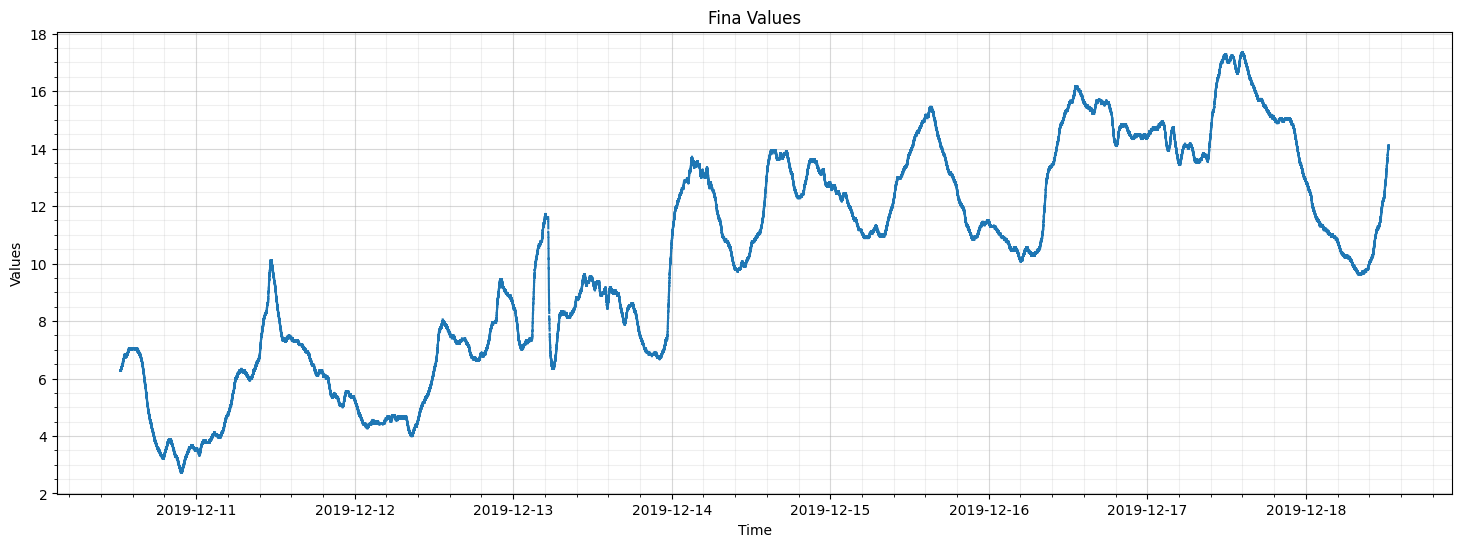

In [16]:
PlotData.plot(df)

### 2. Retrieve Time Series by Date Range

Fetch time series values for a specific date range:

In [53]:
time_start = time.perf_counter()
df = fr.get_fina_time_series_by_date(
    start_date='2019-12-12 00:00:00',
    end_date='2019-12-13 00:00:00',
    step=10
)
print_info(
    feed_id=feed_id,
    start_perf=time_start,
    meta=fr.meta,
    nb_rows=df.shape[0]
)

Data retrieved in 0.002565826005593408s
Feed Id: 1 - File start at 2019-12-10 13:32:20 File end at 2021-05-20 10:36:00
meta: {'interval': 10, 'start_time': 1575981140, 'npoints': 4551863, 'end_time': 1621499760}
Nb days: 527
Shape: 8640 days.


#### Graph values

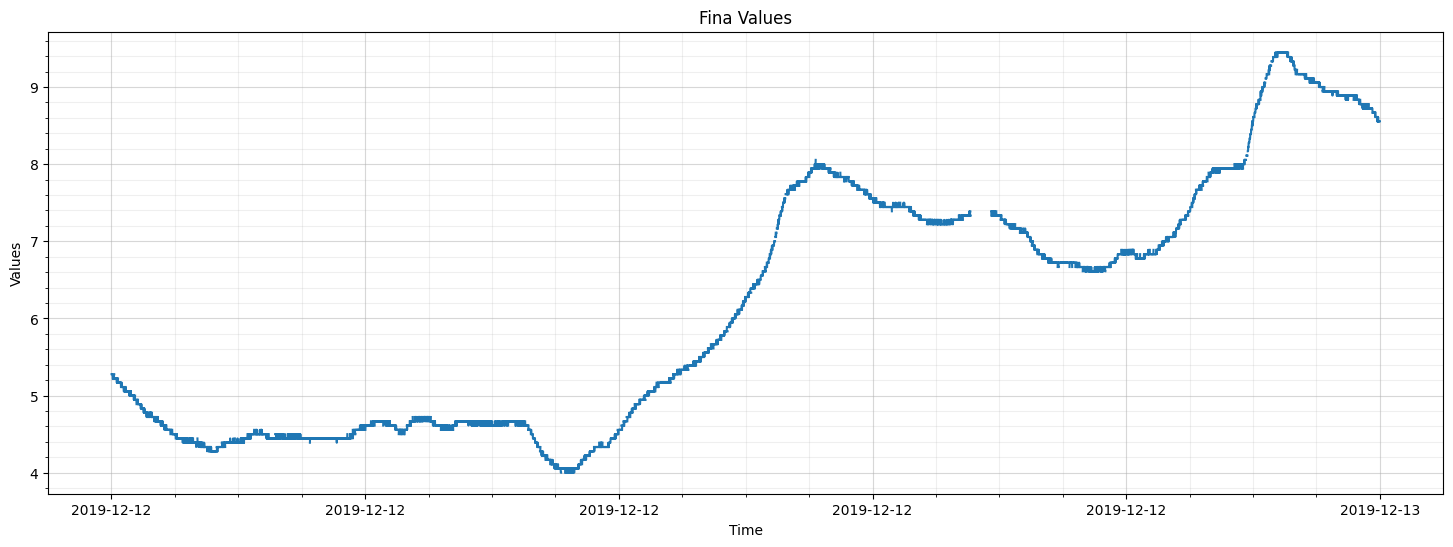

In [19]:
PlotData.plot(df)

### 3. Retrieve Dezoomed Time Series

Fetch time series values with a step larger than the `interval` value in metadata. When the step is larger, the method returns the mean of data points grouped into chunks.

For example:

In [47]:
time_start = time.perf_counter()
df = fr.get_fina_time_series_by_date(
    start_date='2019-12-12 00:00:00',
    end_date='2019-12-13 00:00:00',
    step=3600
)
print_info(
    feed_id=feed_id,
    start_perf=time_start,
    meta=fr.meta,
    nb_rows=df.shape[0]
)

Data retrieved in 0.003121760004432872s
Feed Id: 1 - File start at 2019-12-10 13:32:20 File end at 2021-05-20 10:36:00
meta: {'interval': 10, 'start_time': 1575981140, 'npoints': 4551863, 'end_time': 1621499760}
Nb days: 527
Shape: 24 days.


Here, `step=3600` (1 hour) results in chunks of `3600 / 10 = 360` data points (as `interval=10` seconds).

#### Graph values

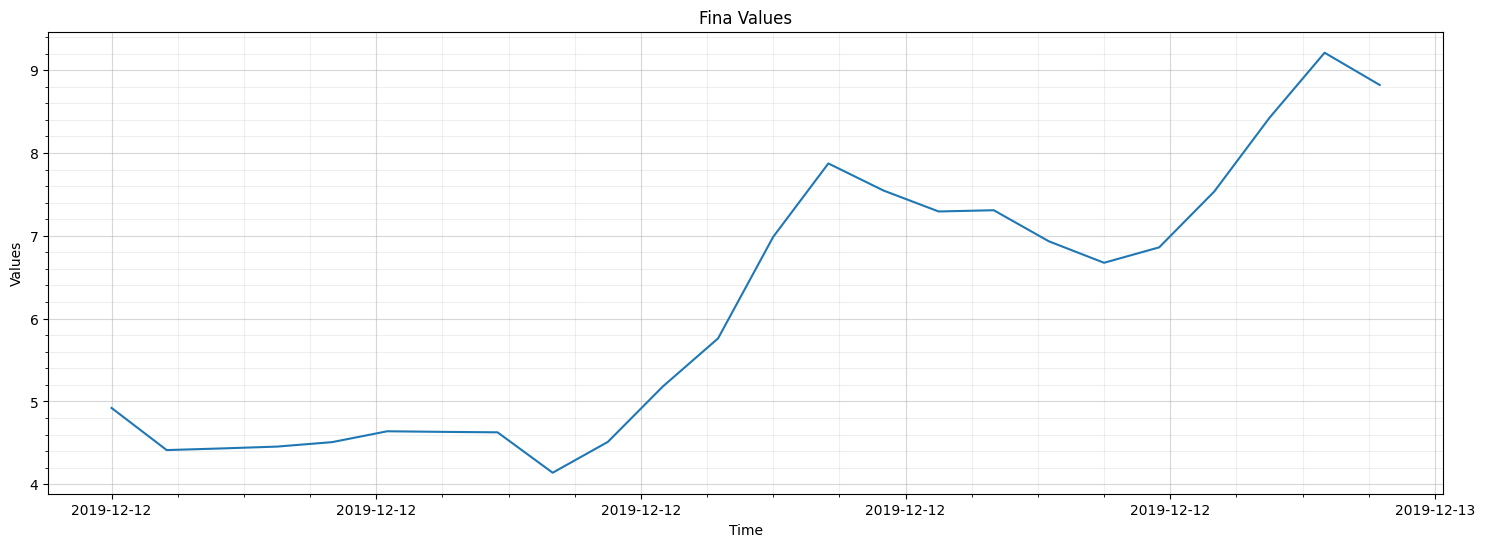

In [48]:
PlotData.plot(df)

### 4. Fill Missing Values (NaN) Using Nearest Values

Replace missing values (NaN) with the nearest valid values, using a backward/forward filling strategy:

In [59]:
df = fr.get_fina_time_series_by_date(
    start_date='2019-12-12 00:00:00',
    end_date='2019-12-13 00:00:00',
    step=10
)

df['filled'] =  NpFillNan.fill_nan_values(
    raw_array=df['values'].values,
    method=FillNanMethod.FORWARD,
    fill_before=True,
    fill_between=True,
    fill_after=True
)

- `method`: Specifies the filling method, here `FORWARD` (forward-fill).
- `fill_before`, `fill_between`, `fill_after`: Control whether to fill values before, between, or after the first and last valid values.

#### Graph

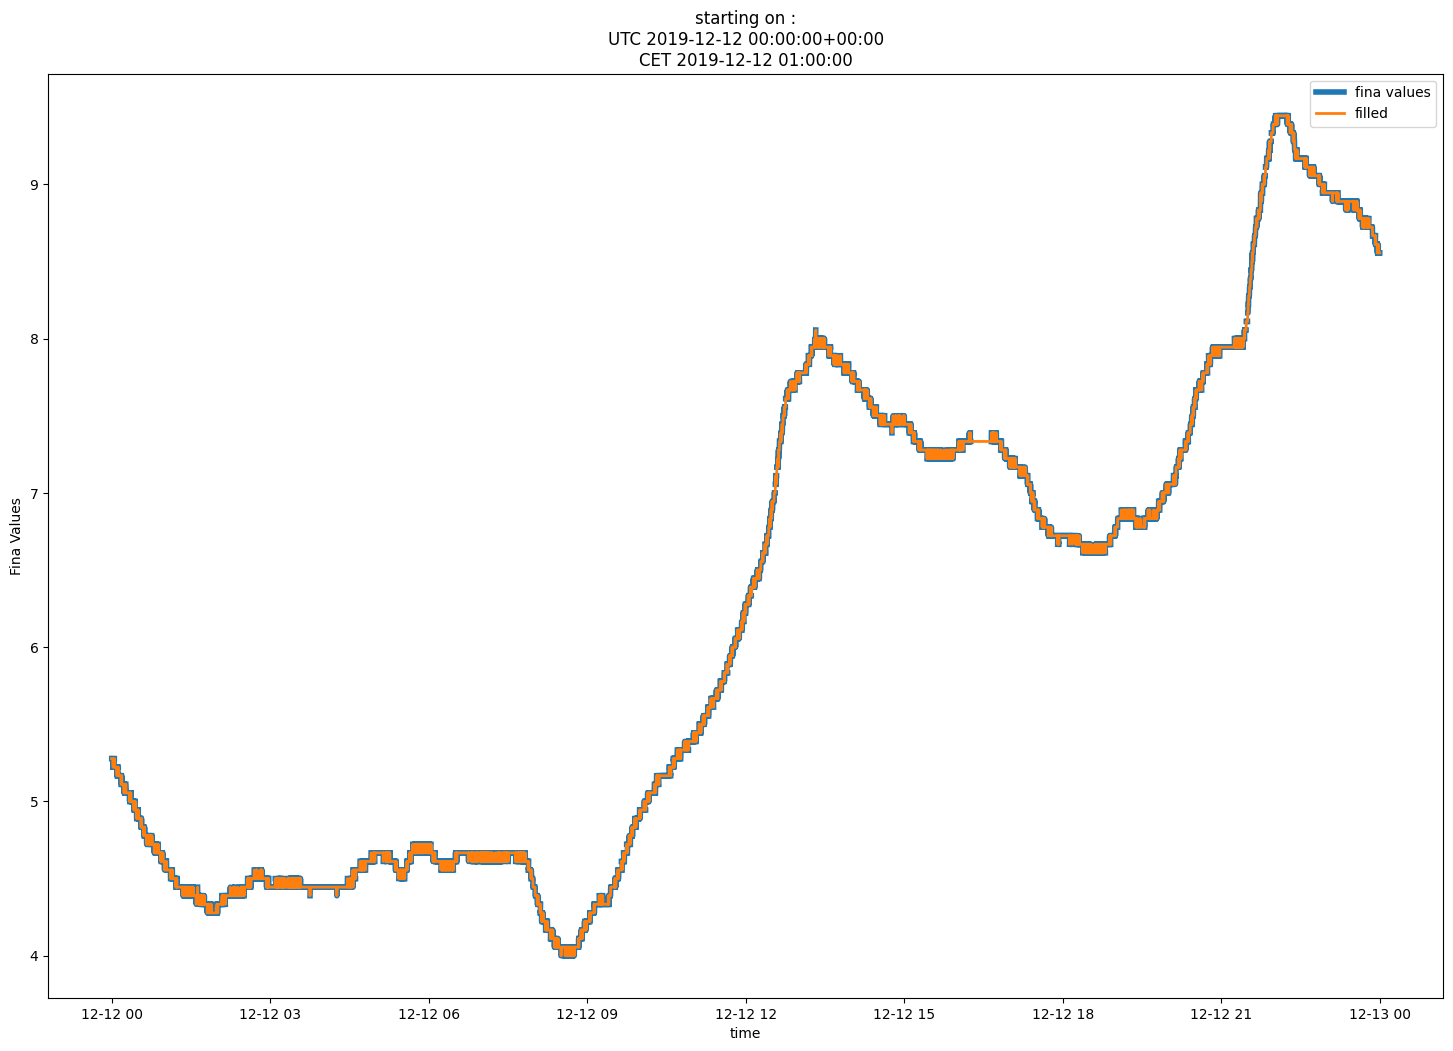

In [60]:
plot_fina_fill_nan(df, fr.start)

### 5. Fill Missing Values with Interpolation

Replace missing values (NaN) using interpolation:

In [62]:
df['filled'] =  NpFillNan.fill_nan_values(
    raw_array=df['values'],
    method=FillNanMethod.INTERPOLATE,
    fill_before=True,
    fill_between=True,
    fill_after=True
)

#### Graph

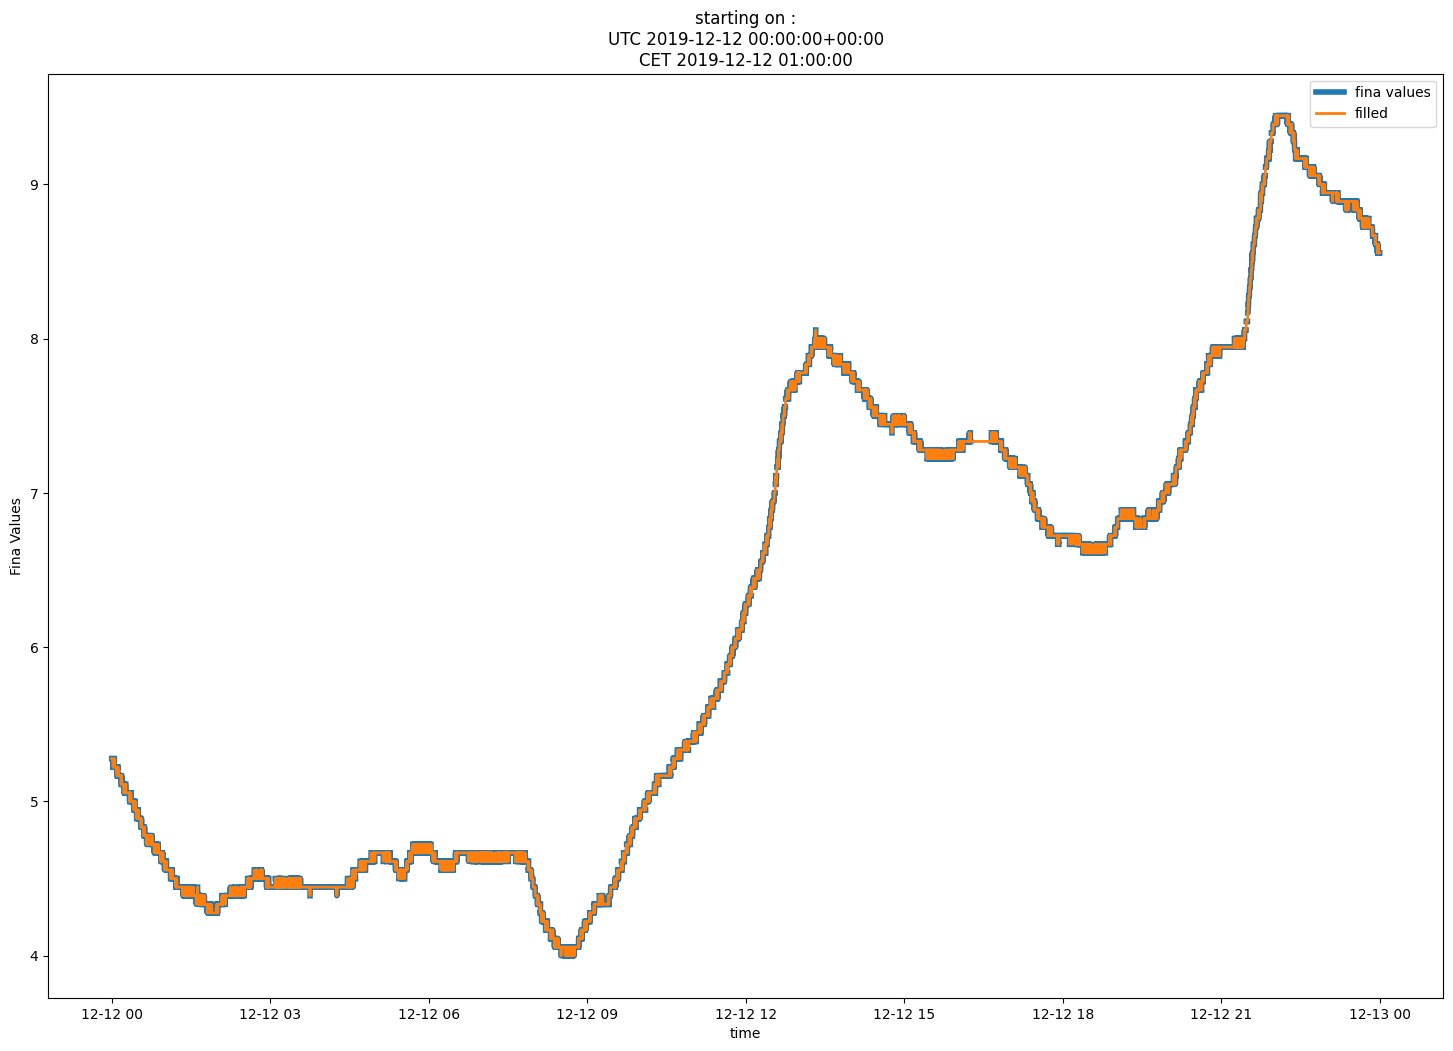

In [63]:
plot_fina_fill_nan(df, fr.start)

## Examples: Retrieving Statistics from PhpFina File

These examples demonstrate how to compute statistics from a PhpFina `.dat` file.

### Initialize `FinaStats`

In [3]:
f_stats = FinaDfStats(
    feed_id=1,
    data_dir=DATA_DIR
)

- `FinaDfStats` Instance: Creates an instance of the `FinaDfStats` class.
- `feed_id`: Identifies the specific data feed.
- `DATA_DIR`: Specifies the directory containing the PhpFina data files.

Once initialized, you can access metadata. For example, a file with `feed_id=1` might return:
```json
{"interval": 10, "start_time": 1575981140, "npoints": 4551863, "end_time": 1621499760}
```

### 1. File Integrity Statistics

Retrieve daily statistics for numeric and NaN values:

In [4]:
feed_id = 1
df = f_stats.get_df_stats(
    max_size=5_000_000,
    stats_type=StatsType.INTEGRITY
)

#### Graph

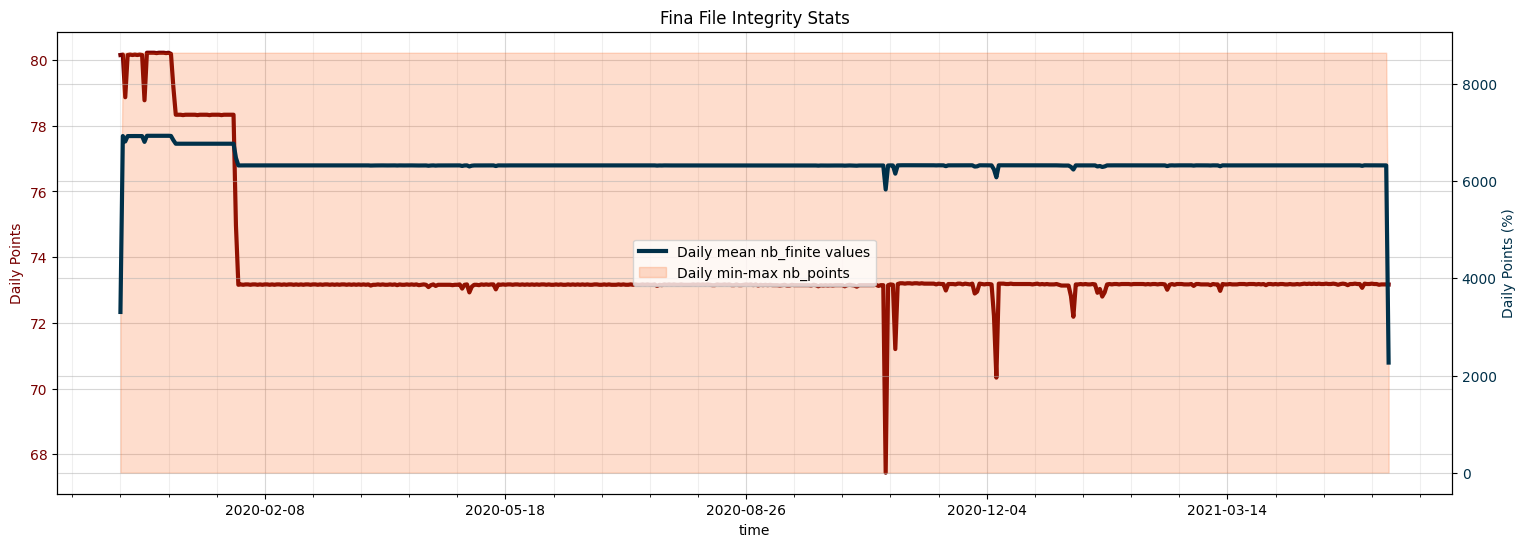

In [7]:
PlotStats.plot_integrity(
    data=df
)

### 2. File Values Statistics

Retrieve daily minimum, mean, and maximum values:

In [8]:
df = f_stats.get_df_stats(
    max_size=5_000_000,
    stats_type=StatsType.VALUES
)

#### Graph

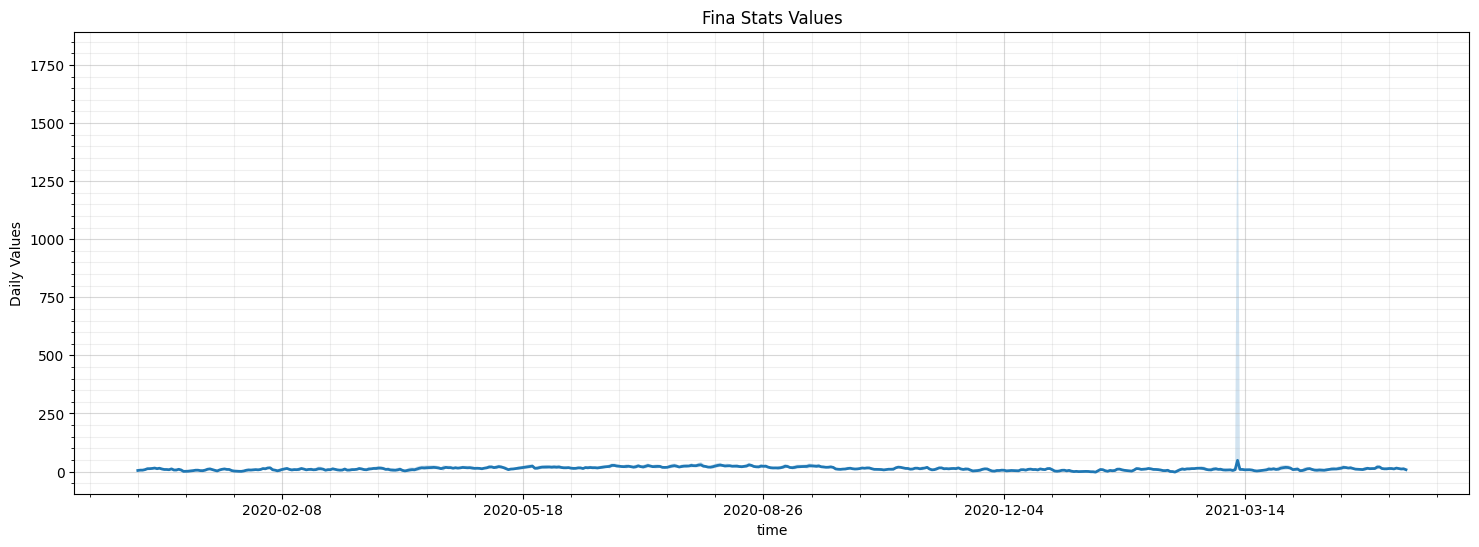

In [9]:
PlotStats.plot_values(
    data=df
)

### 3. File Values Statistics Excluding Errors

Retrieve statistics for values within a specified range, excluding errors or outliers. This ensures robust calculations by filtering out invalid data.

In [ ]:
df=f_stats.get_df_stats(
    max_value=50,
    min_value=-50,
    max_size=5_000_000
)

- `max_value`: Specifies the upper limit for valid data.
- `min_value`: Specifies the lower limit for valid data.
- `Outliers`: Values outside the range `[min_value, max_value]` are excluded and marked as NaN (Not a Number).

#### Graph

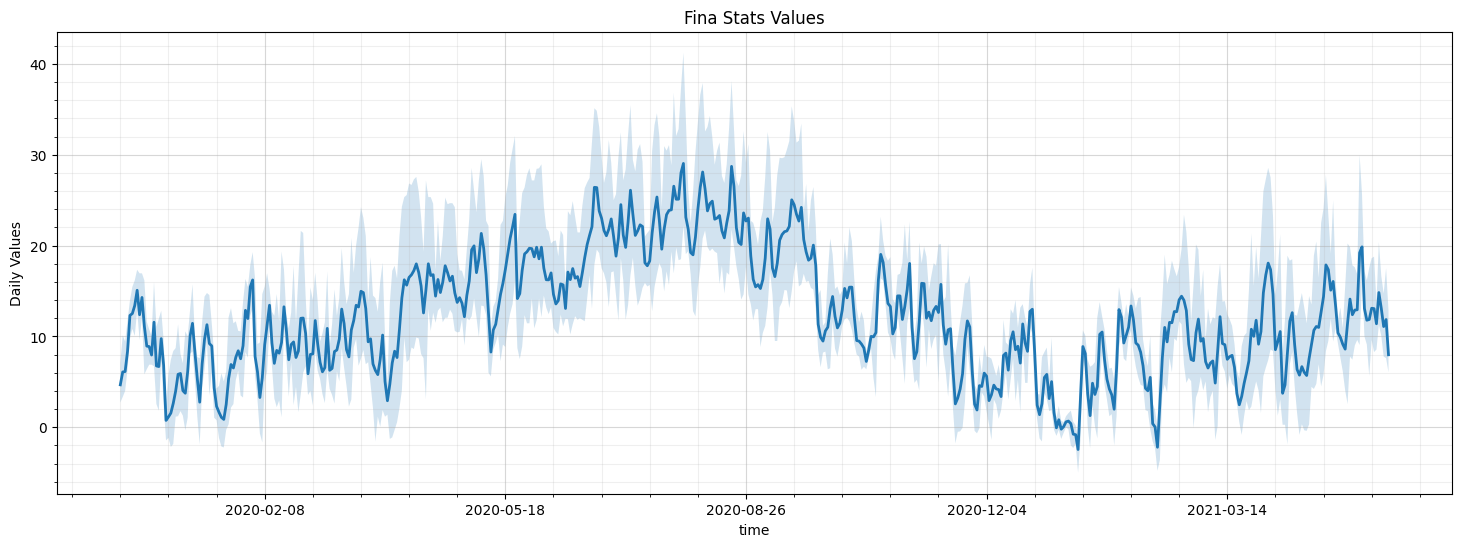

In [11]:
PlotStats.plot_values(
    data=df
)